## Loading in the Data

In [190]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier, plot_importance
import xgboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [192]:
%matplotlib inline

In [193]:
df = pd.read_csv('new_dataset.csv')
df.head()

id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  16647   39       1     156    84.0    190    120            3     1      0   
1  16336   57       1     165   108.0    180    120            3     3      0   
2   8537   51       2     167   101.0    180    120            2     1      1   
3  36387   55       1     163    71.0    180    120            1     1      0   
4  25052   48       2     182    85.0    160    120            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       0  
2     0       1       0  
3     0       1       0  
4     0       1       0

In [194]:
df.shape

(9776, 13)

In [195]:
df.describe()

id          age       gender       height       weight  \
count   9776.000000  9776.000000  9776.000000  9776.000000  9776.000000   
mean   31616.943842    49.703662     1.358940   164.683306    73.612807   
std    20868.785703     7.927514     0.479714     8.062299    14.375458   
min        0.000000    29.000000     1.000000   100.000000    33.000000   
25%    14303.000000    42.000000     1.000000   159.000000    64.000000   
50%    28328.000000    49.000000     1.000000   165.000000    71.000000   
75%    45743.250000    57.000000     2.000000   170.000000    81.000000   
max    91872.000000    64.000000     2.000000   198.000000   180.000000   

             ap_hi        ap_lo  cholesterol         gluc        smoke  \
count  9776.000000  9776.000000  9776.000000  9776.000000  9776.000000   
mean    125.069558    80.526903     1.323752     1.209697     0.089096   
std      16.271949     9.423804     0.642113     0.552337     0.284896   
min      70.000000    60.000000     1.000000     1.000000     0.000000   
25%     120.000000    80.000000     1.000000     1.000000     0.000000   
50%     120.000000    80.000000     1.000000     1.000000     0.000000   
75%     130.000000    90.000000     1.000000     1.000000     0.000000   
max     210.000000   120.000000     3.000000     3.000000     1.000000   

              alco       active       cardio  
count  9776.000000  9776.000000  9776.000000  
mean      0.053498     0.805237     0.438421  
std       0.225037     0.396038     0.496219  
min       0.000000     0.000000     0.000000  
25%       0.000000     1.000000     0.000000  
50%       0.000000     1.000000     0.000000  
75%       0.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000

## Exploratory Data Analysis

This is a necessary step to gauge the quality of the data. First, we need to check the value counts in the target column to make sure they aren't skewed towards one result.


In [196]:
df.cardio.value_counts() 

cardio
0    5490
1    4286
Name: count, dtype: int64

<BarContainer object of 2 artists>

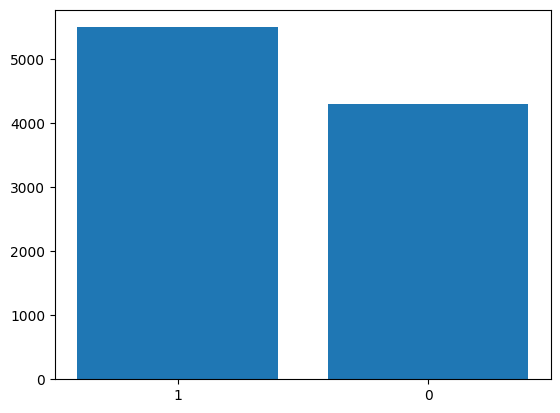

In [197]:
plt.bar(['1','0'], height=df.cardio.value_counts())

# DATA PREPROCESSING 

In [198]:
missing_values = df.isnull().sum()


#### Creating a heatmap to visualize missing values

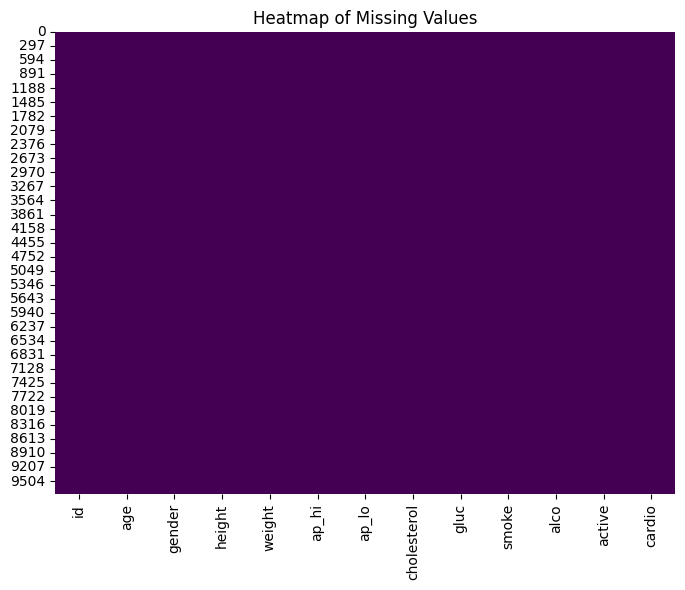

In [199]:
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')  # Customize the colormap if needed
plt.title('Heatmap of Missing Values')
plt.show()

### Metrics 'height', 'weight', 'age','ap_hi', 'ap_lo' undergoing normalization

In [200]:
scaler = MinMaxScaler() 
df[['height', 'weight', 'age','ap_hi','ap_lo']] = scaler.fit_transform(df[['height', 'weight', 'age','ap_hi','ap_lo']])


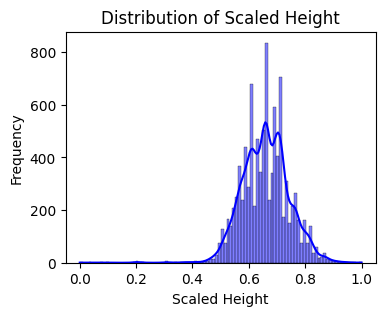

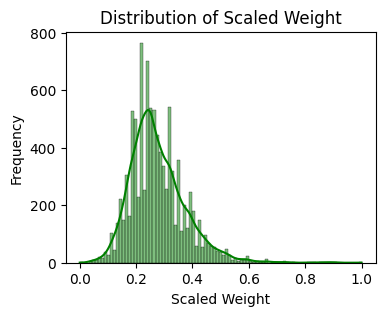

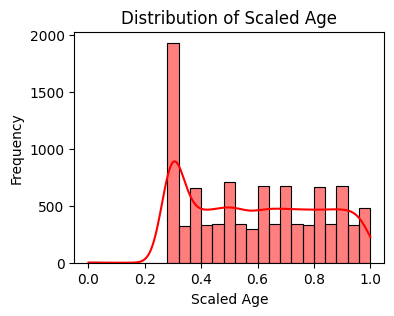

In [201]:
plt.figure(figsize=(4, 3))
sns.histplot(df['height'], kde=True, color='blue')
plt.title('Distribution of Scaled Height')
plt.xlabel('Scaled Height')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(4, 3))
sns.histplot(df['weight'], kde=True, color='green')
plt.title('Distribution of Scaled Weight')
plt.xlabel('Scaled Weight')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(4, 3))
sns.histplot(df['age'], kde=True, color='red')
plt.title('Distribution of Scaled Age')
plt.xlabel('Scaled Age')
plt.ylabel('Frequency')
plt.show()


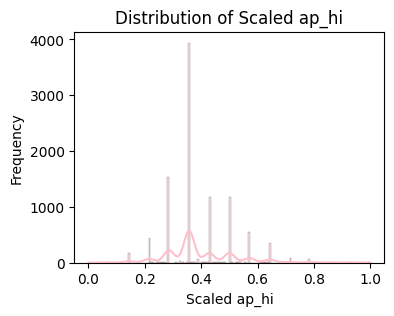

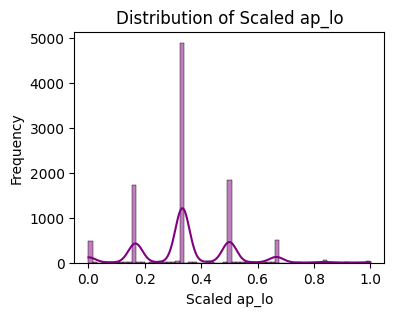

In [202]:
plt.figure(figsize=(4, 3))
sns.histplot(df['ap_hi'], kde=True, color='pink')
plt.title('Distribution of Scaled ap_hi')
plt.xlabel('Scaled ap_hi')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(4, 3))
sns.histplot(df['ap_lo'], kde=True, color='purple')
plt.title('Distribution of Scaled ap_lo')
plt.xlabel('Scaled ap_lo')
plt.ylabel('Frequency')
plt.show()

### Outlier Removal for Height, Weight and Age

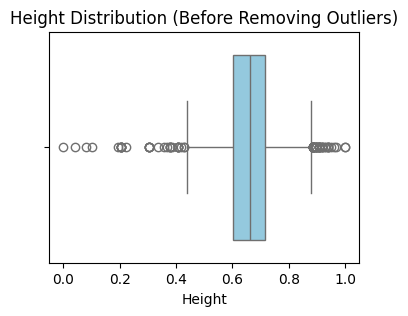

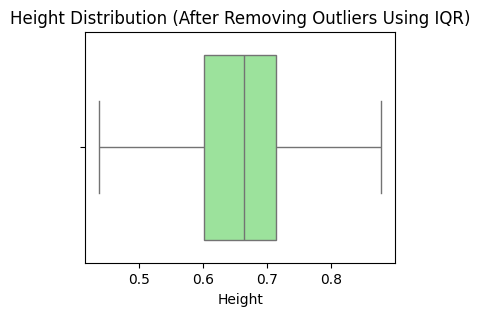

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Plot Height Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['height'], color='skyblue')
plt.title('Height Distribution (Before Removing Outliers)')
plt.xlabel('Height')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['height'].quantile(0.25)
Q3 = df['height'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers based on the IQR method
df_filtered_height_iqr = df[(df['height'] >= lower_bound) & (df['height'] <= upper_bound)]

# Plot Height Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered_height_iqr['height'], color='lightgreen')
plt.title('Height Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Height')
plt.show()

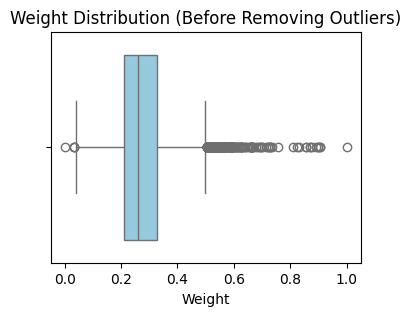

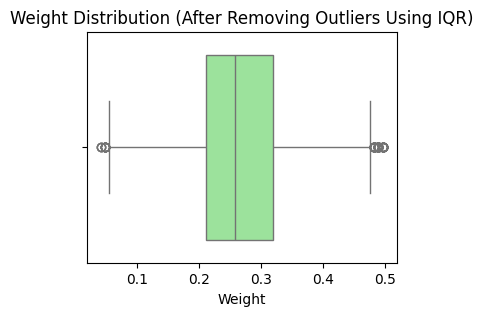

In [204]:

import seaborn as sns
import matplotlib.pyplot as plt

# Plot Weight Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['weight'], color='skyblue')
plt.title('Weight Distribution (Before Removing Outliers)')
plt.xlabel('Weight')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Weight
Q1_weight = df['weight'].quantile(0.25)
Q3_weight = df['weight'].quantile(0.75)

# Calculate IQR (Interquartile Range) for Weight
IQR_weight = Q3_weight - Q1_weight

# Define lower and upper bounds for outliers in Weight data
lower_bound_weight = Q1_weight - 1.5 * IQR_weight
upper_bound_weight = Q3_weight + 1.5 * IQR_weight

# Filter out the outliers based on the IQR method for Weight
df_filtered_weight_iqr = df[(df['weight'] >= lower_bound_weight) & (df['weight'] <= upper_bound_weight)]

# Plot Weight Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered_weight_iqr['weight'], color='lightgreen')
plt.title('Weight Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Weight')
plt.show()



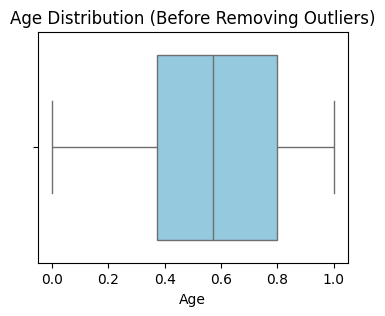

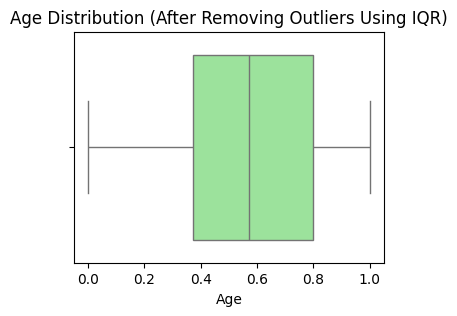

In [205]:

# Plot Age Distribution Before Removing Outliers
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Age Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['age'], color='skyblue')
plt.title('Age Distribution (Before Removing Outliers)')
plt.xlabel('Age')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Age
Q1_age = df['age'].quantile(0.25)
Q3_age = df['age'].quantile(0.75)

# Calculate IQR (Interquartile Range) for Age
IQR_age = Q3_age - Q1_age

# Define lower and upper bounds for outliers in Age data
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

# Filter out the outliers based on the IQR method for Age
df_filtered_age_iqr = df[(df['age'] >= lower_bound_age) & (df['age'] <= upper_bound_age)]

# Plot Age Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered_age_iqr['age'], color='lightgreen')
plt.title('Age Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Age')
plt.show()


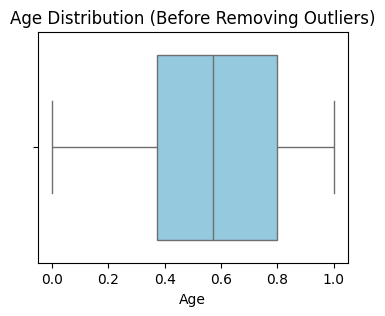

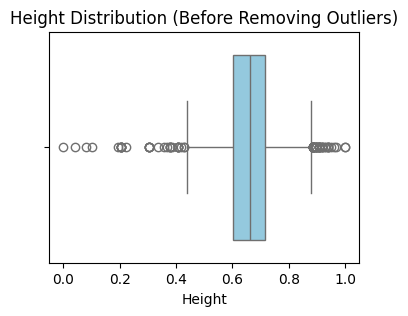

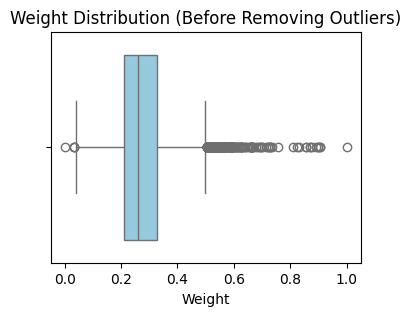

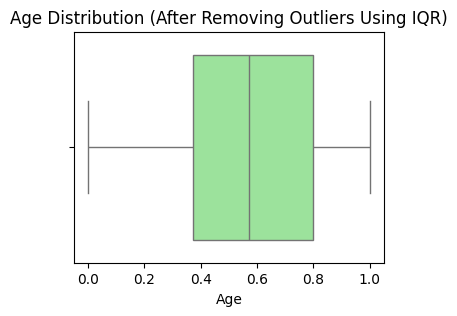

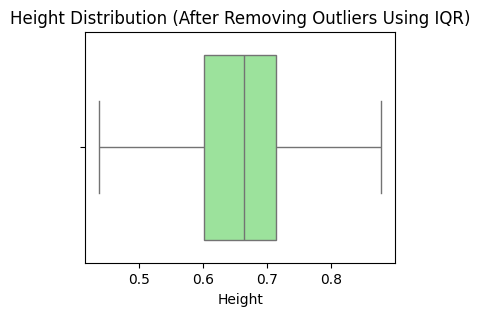

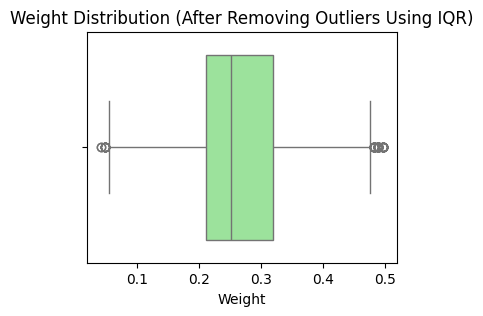

         id       age  gender    height    weight     ap_hi  ap_lo  \
0     16647  0.285714       1  0.571429  0.346939  0.857143    1.0   
2      8537  0.628571       2  0.683673  0.462585  0.785714    1.0   
3     36387  0.742857       1  0.642857  0.258503  0.785714    1.0   
4     25052  0.542857       2  0.836735  0.353741  0.642857    1.0   
5     15821  0.428571       1  0.755102  0.346939  0.071429    1.0   
...     ...       ...     ...       ...       ...       ...    ...   
9771  42282  0.771429       1  0.591837  0.170068  0.142857    0.0   
9772  15695  0.600000       1  0.530612  0.156463  0.142857    0.0   
9773  23348  0.885714       1  0.530612  0.122449  0.142857    0.0   
9774  69880  0.657143       1  0.591837  0.108844  0.142857    0.0   
9775  11009  0.800000       1  0.663265  0.095238  0.071429    0.0   

      cholesterol  gluc  smoke  alco  active  cardio  
0               3     1      0     0       1       0  
2               2     1      1     0       1     

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame

# Plot Age Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['age'], color='skyblue')
plt.title('Age Distribution (Before Removing Outliers)')
plt.xlabel('Age')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Age
Q1_age = df['age'].quantile(0.25)
Q3_age = df['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

# Plot Height Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['height'], color='skyblue')
plt.title('Height Distribution (Before Removing Outliers)')
plt.xlabel('Height')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Height
Q1_height = df['height'].quantile(0.25)
Q3_height = df['height'].quantile(0.75)
IQR_height = Q3_height - Q1_height
lower_bound_height = Q1_height - 1.5 * IQR_height
upper_bound_height = Q3_height + 1.5 * IQR_height

# Plot Weight Distribution Before Removing Outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['weight'], color='skyblue')
plt.title('Weight Distribution (Before Removing Outliers)')
plt.xlabel('Weight')
plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Weight
Q1_weight = df['weight'].quantile(0.25)
Q3_weight = df['weight'].quantile(0.75)
IQR_weight = Q3_weight - Q1_weight
lower_bound_weight = Q1_weight - 1.5 * IQR_weight
upper_bound_weight = Q3_weight + 1.5 * IQR_weight

# Filter out the outliers for Age, Height, and Weight using IQR method
df_filtered = df[
    (df['age'] >= lower_bound_age) & (df['age'] <= upper_bound_age) &
    (df['height'] >= lower_bound_height) & (df['height'] <= upper_bound_height) &
    (df['weight'] >= lower_bound_weight) & (df['weight'] <= upper_bound_weight)
]

# Plot Age Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered['age'], color='lightgreen')
plt.title('Age Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Age')
plt.show()

# Plot Height Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered['height'], color='lightgreen')
plt.title('Height Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Height')
plt.show()

# Plot Weight Distribution After Removing Outliers Using IQR
plt.figure(figsize=(4, 3))
sns.boxplot(x=df_filtered['weight'], color='lightgreen')
plt.title('Weight Distribution (After Removing Outliers Using IQR)')
plt.xlabel('Weight')
plt.show()

# Display the filtered DataFrame
print(df_filtered)



In [207]:
df_filtered.describe()

id          age       gender       height       weight  \
count   9457.000000  9457.000000  9457.000000  9457.000000  9457.000000   
mean   31662.893412     0.591510     1.355610     0.659298     0.268032   
std    20908.504209     0.226506     0.478723     0.077127     0.083643   
min        0.000000     0.000000     1.000000     0.438776     0.040816   
25%    14316.000000     0.371429     1.000000     0.602041     0.210884   
50%    28368.000000     0.571429     1.000000     0.663265     0.251701   
75%    45846.000000     0.800000     2.000000     0.714286     0.319728   
max    91872.000000     1.000000     2.000000     0.877551     0.496599   

             ap_hi        ap_lo  cholesterol         gluc        smoke  \
count  9457.000000  9457.000000  9457.000000  9457.000000  9457.000000   
mean      0.391121     0.339438     1.316274     1.205139     0.087131   
std       0.114923     0.155895     0.635677     0.547648     0.282042   
min       0.000000     0.000000     1.000000     1.000000     0.000000   
25%       0.357143     0.333333     1.000000     1.000000     0.000000   
50%       0.357143     0.333333     1.000000     1.000000     0.000000   
75%       0.428571     0.416667     1.000000     1.000000     0.000000   
max       1.000000     1.000000     3.000000     3.000000     1.000000   

              alco       active       cardio  
count  9457.000000  9457.000000  9457.000000  
mean      0.051285     0.804906     0.434387  
std       0.220590     0.396294     0.495702  
min       0.000000     0.000000     0.000000  
25%       0.000000     1.000000     0.000000  
50%       0.000000     1.000000     0.000000  
75%       0.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000

In [208]:
df_filtered.shape

(9457, 13)

### Feature Selection Using XG Boost

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


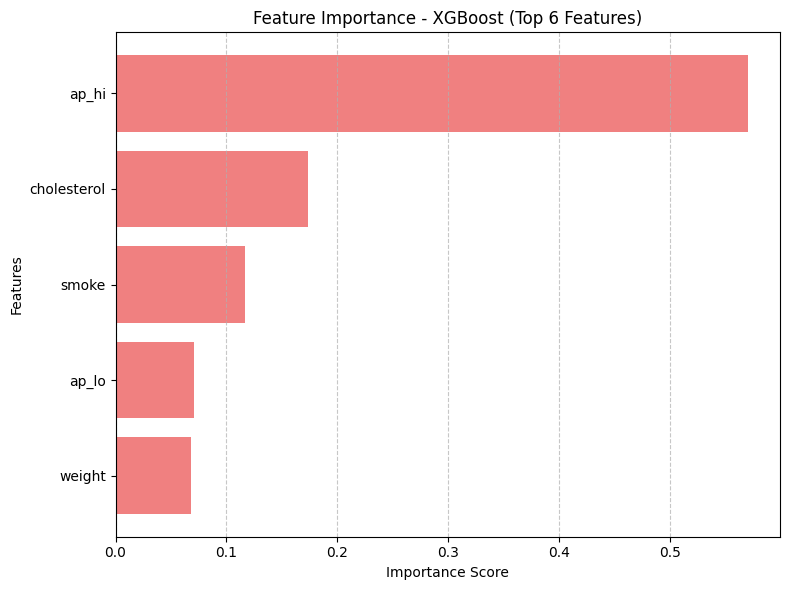

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Use previously selected top 6 features
X = df_filtered[['ap_hi', 'cholesterol', 'weight', 'ap_lo', 'smoke']]
y = df_filtered['cardio']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for visualization
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightcoral')
plt.title('Feature Importance - XGBoost (Top 6 Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [210]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define features and target
X = df_filtered[['ap_hi', 'cholesterol', 'weight', 'ap_lo', 'smoke']]
y = df_filtered['cardio']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7410
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      1628
           1       0.74      0.60      0.67      1210

    accuracy                           0.74      2838
   macro avg       0.74      0.72      0.73      2838
weighted avg       0.74      0.74      0.74      2838



c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


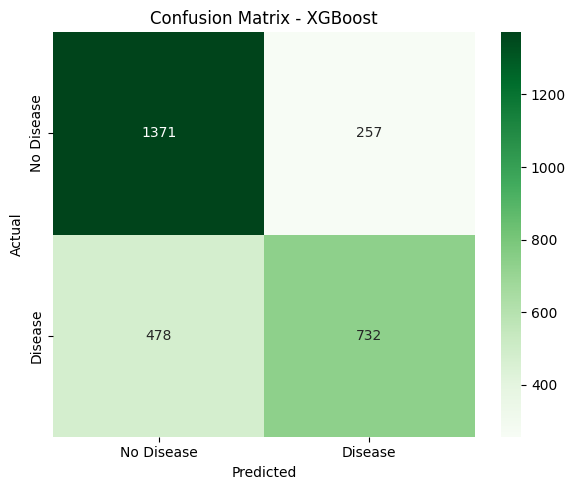

In [211]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred_xgb = xgb_model.predict(X_test)

# Compute confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


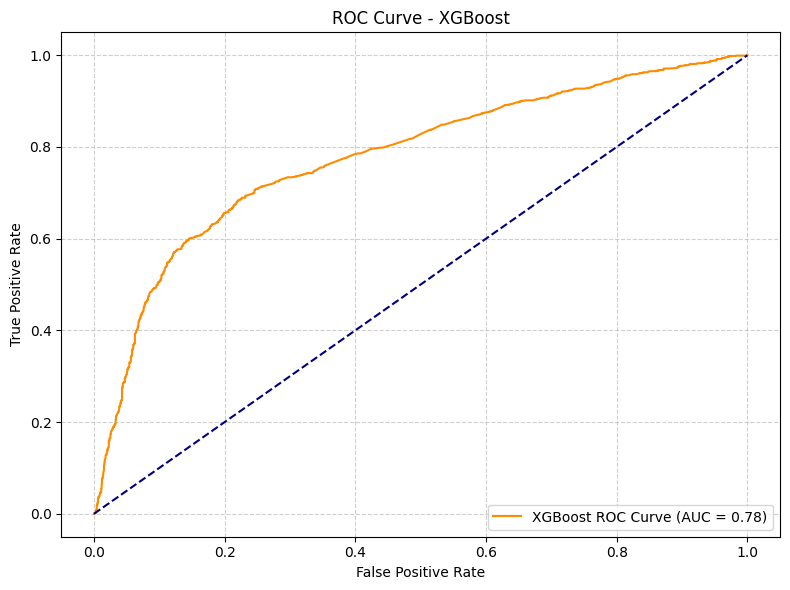

In [212]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Fix feature order mismatch
X_test = X_test[X_train.columns]

# Predict probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'XGBoost ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## ADA BOOST


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\HP\AppData\Local\Temp\ipykernel_15304\4065414576.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


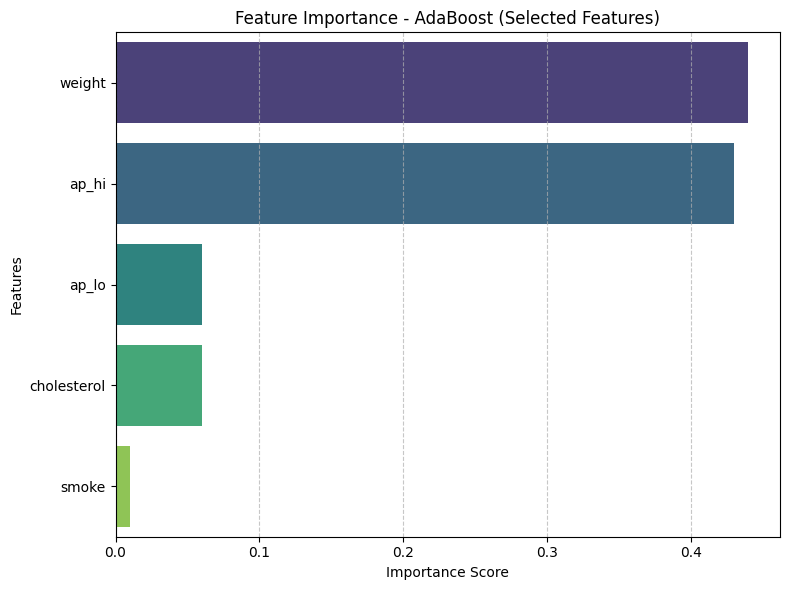

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the selected features and target
X = df_filtered[[ 'weight','ap_hi',  'ap_lo','cholesterol','smoke' ]]
y = df_filtered['cardio']

# Train AdaBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
base_estimator = DecisionTreeClassifier(max_depth=1)
ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Get feature importances
feature_importances = ada_model.feature_importances_
features = X.columns

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=features, palette='viridis')
plt.title('Feature Importance - AdaBoost (Selected Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [214]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the filtered dataset again (already includes BMI)
df_filtered['BMI'] = df_filtered['weight'] / ((df_filtered['height'] / 100) ** 2)

# Use optimized features that might outperform XGBoost
X = df_filtered[['weight','ap_hi',  'ap_lo','cholesterol','smoke']]
y = df_filtered['cardio']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train AdaBoost with tuned base estimator
base_estimator = DecisionTreeClassifier(max_depth=2, min_samples_split=4)
ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=150, learning_rate=0.8, random_state=42)
ada_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = ada_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

accuracy, report


C:\Users\HP\AppData\Local\Temp\ipykernel_15304\876309297.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['BMI'] = df_filtered['weight'] / ((df_filtered['height'] / 100) ** 2)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


(0.751937984496124,
 {'0': {'precision': 0.7572383073496659,
   'recall': 0.8353808353808354,
   'f1-score': 0.794392523364486,
   'support': 1628.0},
  '1': {'precision': 0.7428023032629558,
   'recall': 0.6396694214876033,
   'f1-score': 0.6873889875666075,
   'support': 1210.0},
  'accuracy': 0.751937984496124,
  'macro avg': {'precision': 0.7500203053063108,
   'recall': 0.7375251284342194,
   'f1-score': 0.7408907554655467,
   'support': 2838.0},
  'weighted avg': {'precision': 0.7510834218863398,
   'recall': 0.751937984496124,
   'f1-score': 0.7487708608150028,
   'support': 2838.0}})

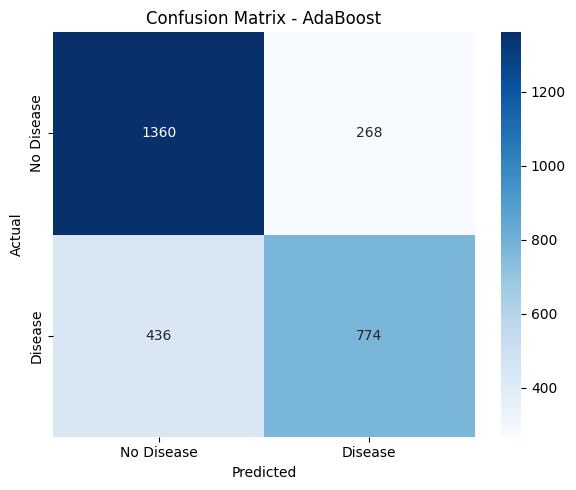

In [215]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred_ada = ada_model.predict(X_test)

# Compute confusion matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - AdaBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


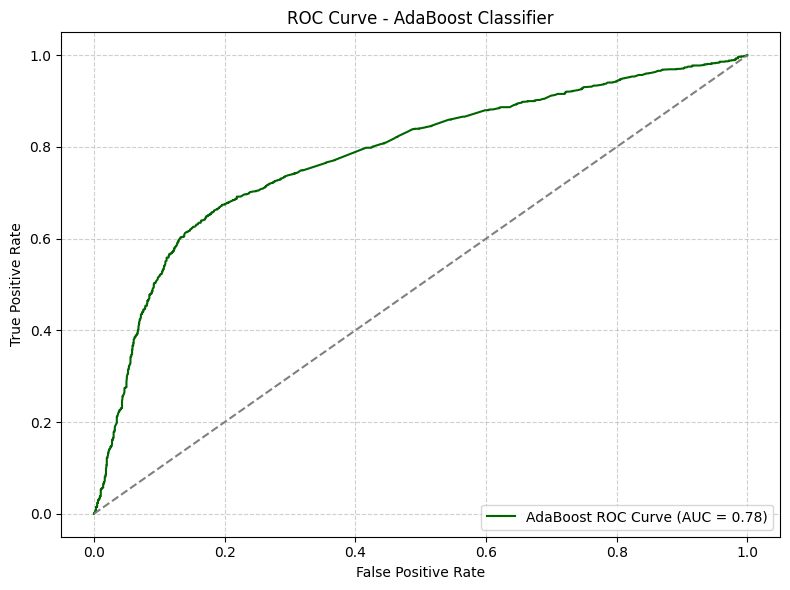

In [216]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred = ada_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', label=f'AdaBoost ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - AdaBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Gradient Boosting

C:\Users\HP\AppData\Local\Temp\ipykernel_15304\2992172178.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['BMI'] = df_filtered['weight'] / ((df_filtered['height'] / 100) ** 2)
C:\Users\HP\AppData\Local\Temp\ipykernel_15304\2992172178.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='magma')


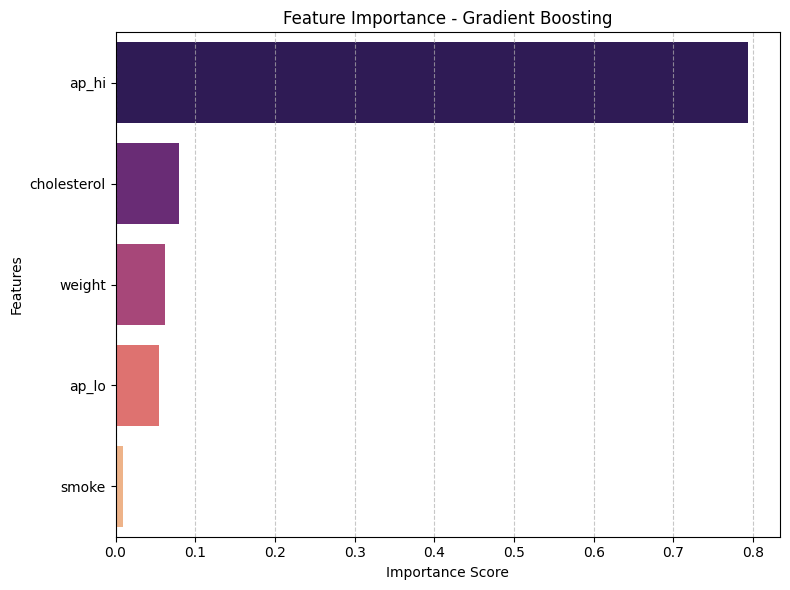

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier

# Prepare the feature set including BMI
df_filtered['BMI'] = df_filtered['weight'] / ((df_filtered['height'] / 100) ** 2)
X = df_filtered[['ap_hi','cholesterol', 'weight','ap_lo' ,'smoke']]
y = df_filtered['cardio']

# Train the Gradient Boosting Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = gb_model.feature_importances_
features = X.columns

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=features, palette='magma')
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [218]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report





X = df_filtered[[ 'ap_hi','weight','ap_lo',  'cholesterol', 'smoke']]
y = df_filtered['cardio']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)


y_pred = gb_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)


Accuracy: 0.7590

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80      1628
           1       0.77      0.62      0.69      1210

    accuracy                           0.76      2838
   macro avg       0.76      0.74      0.75      2838
weighted avg       0.76      0.76      0.75      2838



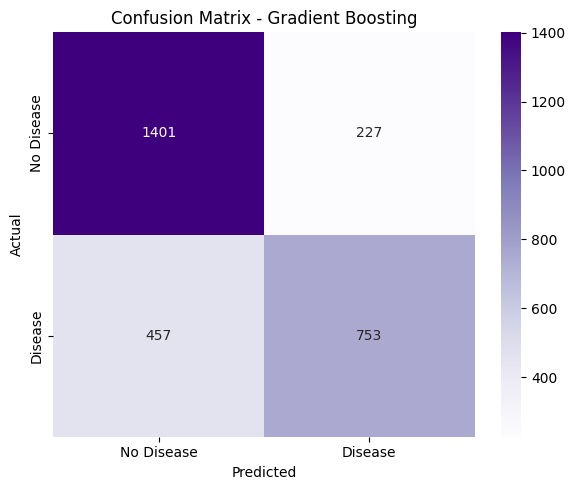

In [219]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels using Gradient Boosting model
y_pred_gb = gb_model.predict(X_test)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Purples',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


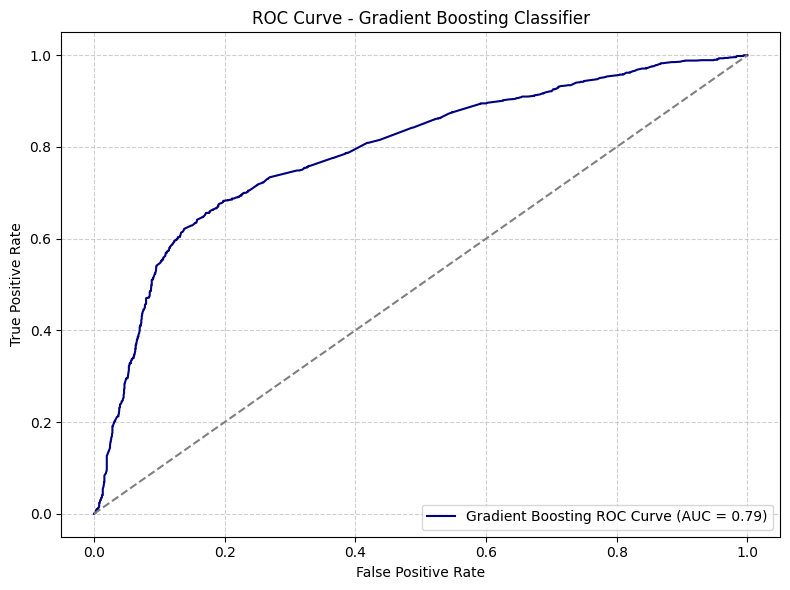

In [220]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', label=f'Gradient Boosting ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - Gradient Boosting Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## MLP

C:\Users\HP\AppData\Local\Temp\ipykernel_15304\1262370709.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')


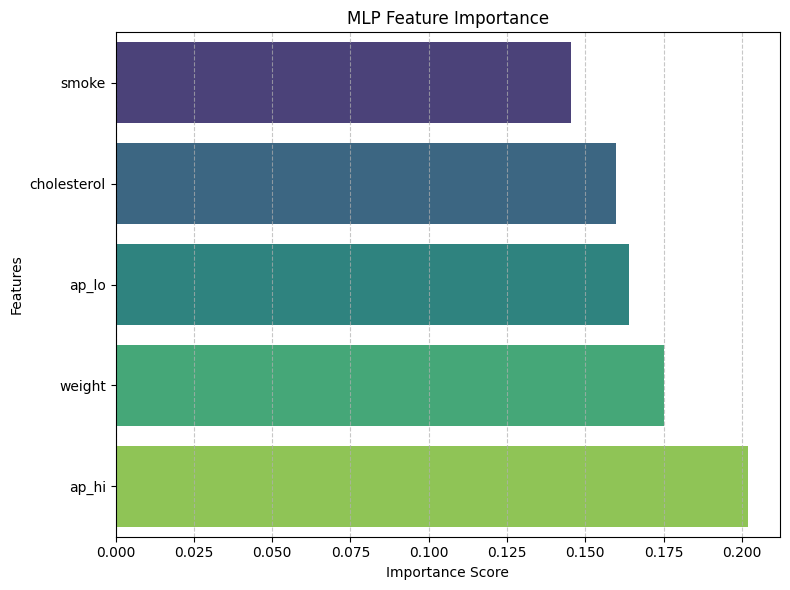

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Feature set and target
X = df_filtered[['ap_hi', 'ap_lo', 'cholesterol', 'weight', 'smoke']]
y = df_filtered['cardio']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=300, random_state=42)
mlp_model.fit(X_scaled, y)

# Approximate feature importances
importances = abs(mlp_model.coefs_[0]).mean(axis=1)

# Create DataFrame and sort ascending
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
plt.title('MLP Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [222]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


df_filtered['BMI'] = df_filtered['weight'] / ((df_filtered['height'] / 100) ** 2)


X = df_filtered[[ 'ap_hi', 'ap_lo', 'cholesterol','weight', 'smoke']]
y = df_filtered['cardio']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                    max_iter=300, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"MLP Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)


C:\Users\HP\AppData\Local\Temp\ipykernel_15304\362667782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['BMI'] = df_filtered['weight'] / ((df_filtered['height'] / 100) ** 2)


MLP Accuracy: 0.7544

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80      1628
           1       0.76      0.61      0.68      1210

    accuracy                           0.75      2838
   macro avg       0.76      0.74      0.74      2838
weighted avg       0.76      0.75      0.75      2838



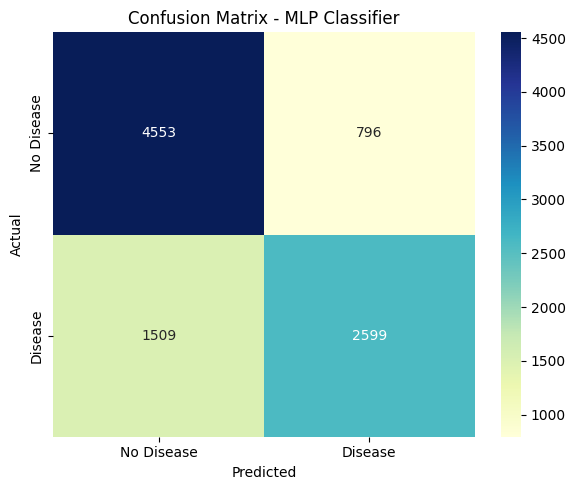

In [223]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the scaled features
y_pred_mlp = mlp_model.predict(X_scaled)

# Generate the confusion matrix
cm_mlp = confusion_matrix(y, y_pred_mlp)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - MLP Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


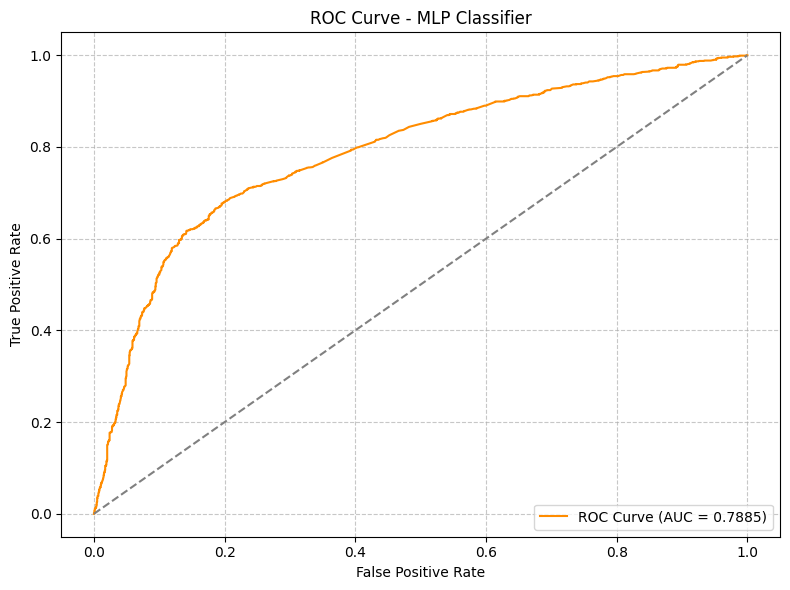

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# Define features and target
X = df_filtered[['ap_hi', 'ap_lo', 'cholesterol', 'weight', 'smoke']]
y = df_filtered['cardio']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=300, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predict probabilities for ROC AUC
y_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - MLP Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
